## ニューロンの発火についての実装
- 引用："Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.

### この章のまとめ
-  スパイキングニューラルネットワークは入力がスパイクで出力もスパイク 
1. 細胞膜をコンデンサ、イオンチャネルを抵抗として擬似的に模式
1. modelの式から入力がない場合の膜電位の時間変化を描画
1. snn.Lapicqueを用いて同様の結果を描画
1. Inputで電流を流した場合の膜電位の変化を描画
1. 発火したら膜電位が0に下がるように実装

In [126]:

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [127]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential 
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

#### 様々なニューラルネットワークモデルとその特性

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="100%">

#### 膜電位の導出

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="60%">

- 導出した式を一定時間に拡張した式

$$U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\big(-U(t) + RI_{\rm in}(t)\big)$$

In [128]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
    tau = R*C
    U = U + (time_step/tau)*(-U + I*R)
    return U

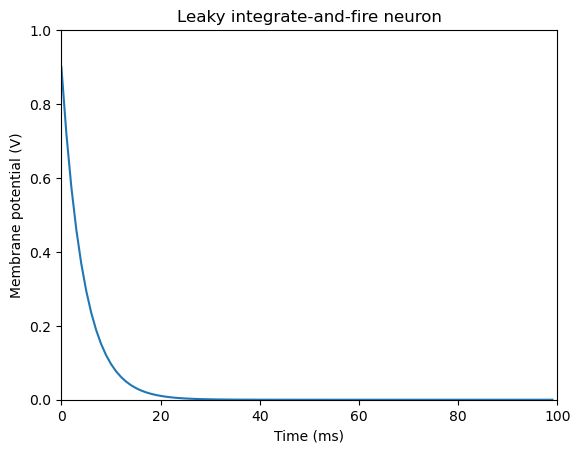

In [129]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
    U_trace.append(U)
    U = leaky_integrate_neuron(U)  # solve next step of U

plt.plot(U_trace)
plt.xlim(0, num_steps)
plt.ylim(0, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (V)')
plt.title('Leaky integrate-and-fire neuron')
plt.show()


#### LapocqueニューロンモデルのSNNtorchでの実装

In [130]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=R*C
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)
#この関数はspike_outと膜電位を返す。詳しくはLIF.pyに書いています

In [131]:

mem = torch.ones(1) * 0.9  #膜電位を0.9で初期化
cur_in = torch.zeros(num_steps)  # 今回は回路に電流が入らないことを想定
spk_out = torch.zeros(1)  # スパイクの初期値を０にする

In [132]:
# 膜電位を記録するために、リストを作成して記録する
mem_rec = [mem]

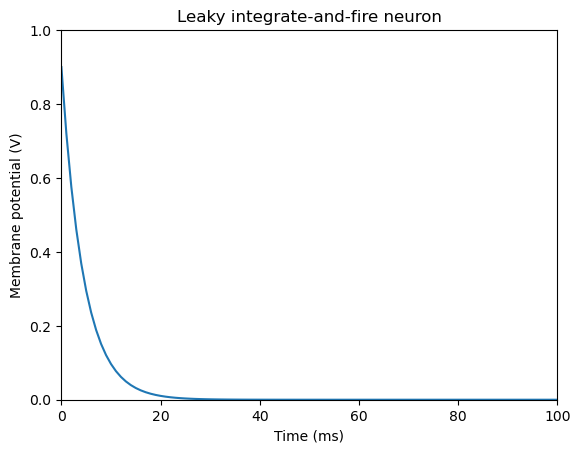

In [133]:
#　回路に電流が入らない場合を考得る。普段は入力の電流がある
for step in range(num_steps):
    spk_out, mem = lif1(cur_in[step], mem)

# Store recordings of membrane potential
    mem_rec.append(mem)

# crunch the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)


plt.plot(mem_rec)
plt.xlim(0, num_steps)
plt.ylim(0, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (V)')
plt.title('Leaky integrate-and-fire neuron')
plt.show()

### 回路に電流の入力を与えてみる

膜電位の一般解は以下の式で表される
$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

これに対して時間０で入力が０ならば式は以下で表される
$$U_{\rm mem}(t)=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

t=10に対してI=100mAのものを与えて実行してみる

In [134]:
cur_in=torch.cat((torch.zeros(10),torch.ones(190)*0.1),0)

mem=torch.zeros(1)
spk_out=torch.zeros(1)
mem_rec=[mem]

In [135]:
num_steps=200

for step in range(num_steps):
    spk_out,mem=lif1(cur_in[step],mem)
    mem_rec.append(mem)

mem_rec=torch.stack(mem_rec)
#Dim=0でスタックを実行


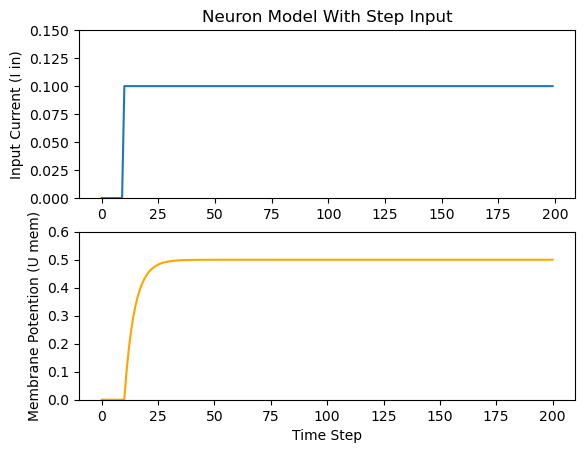

In [136]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Neuron Model With Step Input')
plt.plot(cur_in)
plt.ylim(0,0.15)
plt.ylabel('Input Current (I in)')

plt.subplot(2,1,2)
plt.plot(mem_rec,color='orange')
plt.ylim(0,0.6)
plt.xlabel('Time Step')
plt.ylabel('Membrane Potention (U mem)')
plt.show()



In [137]:
cur_in1 = torch.cat((torch.zeros(10),torch.ones(20)*(0.1),torch.zeros(170)),0)
mem=torch.zeros(1)
spk_out=torch.zeros(1)
mem_rec1=[mem]#初期値を0にしたリストを作成

In [138]:
for step in range(num_steps):
    spk_out,mem=lif1(cur_in1[step],mem)
    mem_rec1.append(mem)
mem_rec1=torch.stack(mem_rec1)


#### 30秒で入力が落ちる電流を入力する
- 電流が入ると膜電位は立ち上がるが、入力がなくなると時定数にしたがって下がる

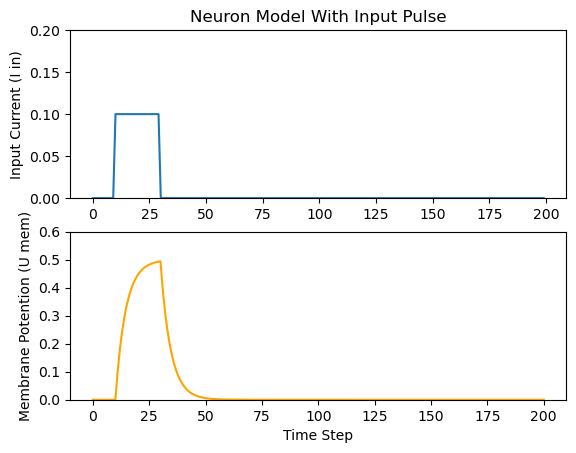

In [139]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Neuron Model With Input Pulse')
plt.plot(cur_in1)
plt.ylim(0,0.20)
plt.ylabel('Input Current (I in)')

plt.subplot(2,1,2)
plt.plot(mem_rec1,color='orange')
plt.ylim(0,0.600)
plt.xlabel('Time Step')
plt.ylabel('Membrane Potention (U mem)')
plt.show()


#### 先ほどと同じ電荷の量で時間を短くした入力を入れてみる

In [140]:
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
    spk_out, mem = lif1(cur_in2[step], mem)
    mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

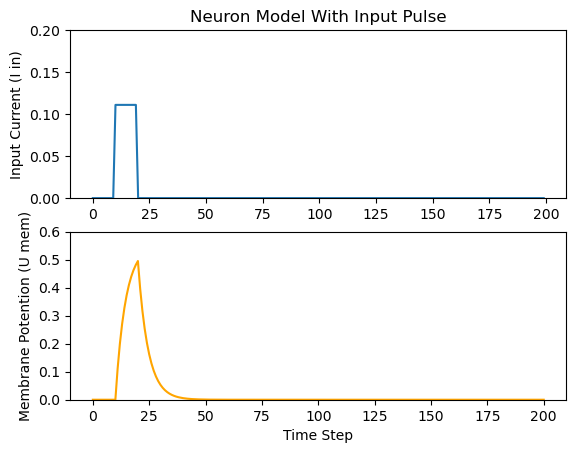

In [141]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Neuron Model With Input Pulse')
plt.plot(cur_in2)
plt.ylim(0,0.20)
plt.ylabel('Input Current (I in)')

plt.subplot(2,1,2)
plt.plot(mem_rec2,color='orange')
plt.ylim(0,0.600)
plt.xlabel('Time Step')
plt.ylabel('Membrane Potention (U mem)')
plt.show()

#### 同じ電荷のままもっと短い時間で実行したもの

In [142]:
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
    spk_out, mem = lif1(cur_in3[step], mem)
    mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

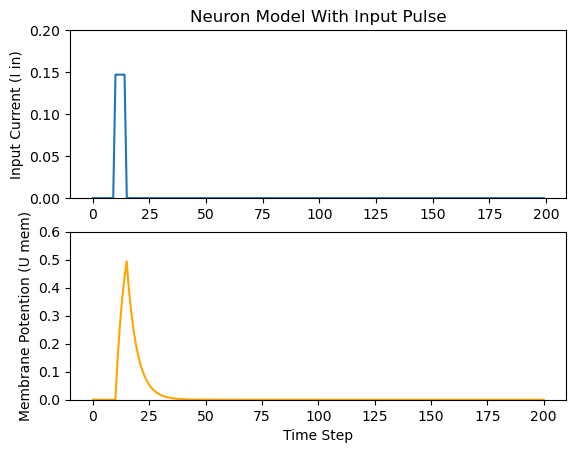

In [143]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Neuron Model With Input Pulse')
plt.plot(cur_in3)
plt.ylim(0,0.20)
plt.ylabel('Input Current (I in)')

plt.subplot(2,1,2)
plt.plot(mem_rec3,color='orange')
plt.ylim(0,0.600)
plt.xlabel('Time Step')
plt.ylabel('Membrane Potention (U mem)')
plt.show()

#### これまでのものを重ねて図で表してみる

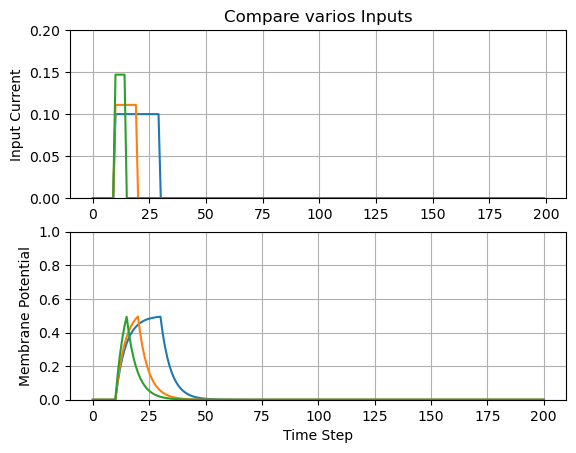

In [144]:
fig=plt.figure()
ax=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax.set_ylim(0,0.20)
ax.set_title('Compare varios Inputs')
ax.set_ylabel('Input Current')
ax.plot(cur_in1)
ax.plot(cur_in2)
ax.plot(cur_in3)
ax.grid(True)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Membrane Potential')
ax2.set_xlabel('Time Step')
ax2.plot(mem_rec1)
ax2.plot(mem_rec2)
ax2.plot(mem_rec3)
ax2.grid(True)


#### 入力の電流を極端に短い時間にする

- 入力の電流の大きさを極端に小さくすることで擬似的にスパイク入力を模倣する

In [145]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10), torch.ones(1)*0.5, torch.zeros(189)), 0)  # input only on for 1 time step
mem = torch.zeros(1) 
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
    spk_out, mem = lif1(cur_in4[step], mem)
    mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

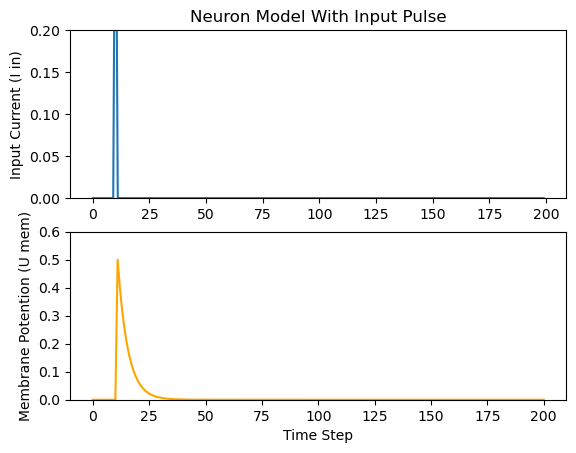

In [146]:
plt.figure()

plt.subplot(2,1,1)
plt.title('Neuron Model With Input Pulse')
plt.plot(cur_in4)
plt.ylim(0,0.20)
plt.ylabel('Input Current (I in)')

plt.subplot(2,1,2)
plt.plot(mem_rec4,color='orange')
plt.ylim(0,0.600)
plt.xlabel('Time Step')
plt.ylabel('Membrane Potention (U mem)')
plt.show()

#### 入力に対しての出力のスパイクの挙動について

- スパイクは閾値を超えたら発火するように設定する。
- 本来の膜電位の挙動と酷似


<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="60%">


In [147]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
    tau_mem = R*C
    spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
    mem = mem + (time_step/tau_mem)*(-mem + cur*R)
    return mem, spk

In [148]:
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
    mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
    mem_rec.append(mem)
    spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

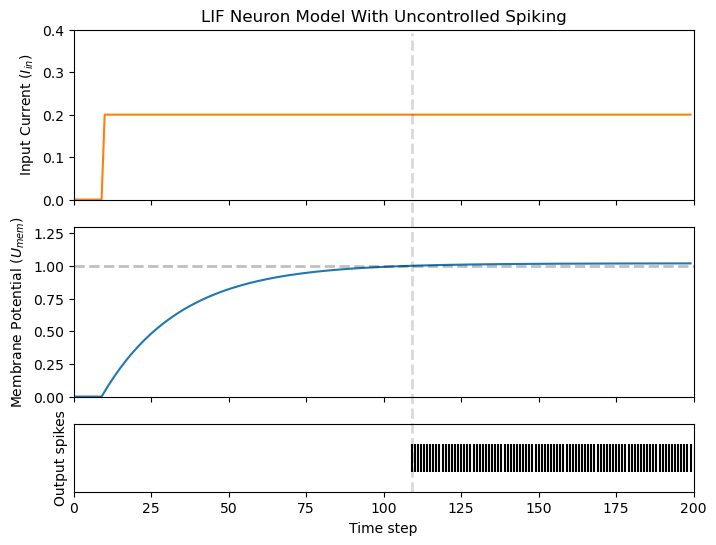

In [150]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3, 
                 title="LIF Neuron Model With Uncontrolled Spiking")

#### 膜電位を発火した後に０になるように設定する

In [151]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
    tau_mem = R*C
    spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
    mem = mem + (time_step/tau_mem)*(-mem + cur*R)- spk*threshold 
    return mem, spk

In [152]:
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
    mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
    mem_rec.append(mem)
    spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

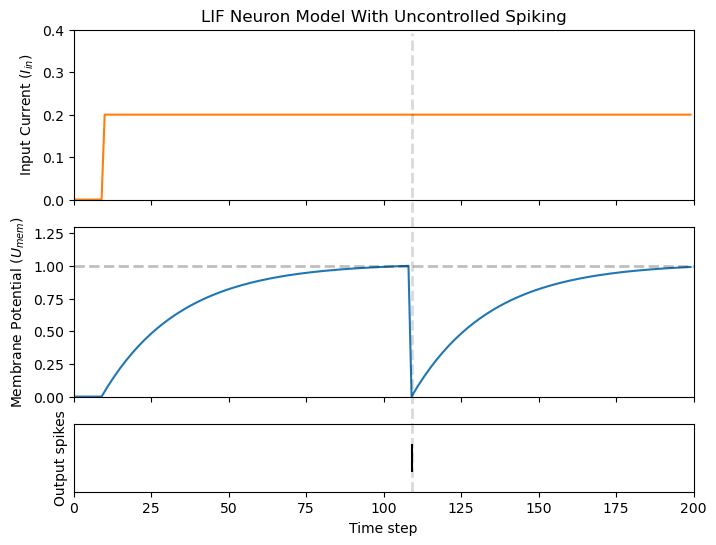

tensor([False, False, False, False,  True, False, False, False, False, False])


In [153]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3, 
                 title="LIF Neuron Model With Uncontrolled Spiking")

#スパイクの発火した箇所を表示
print(spk_rec[105:115].view(-1))

#### 入力電流の大きさを小さくすると発火しやすくなる

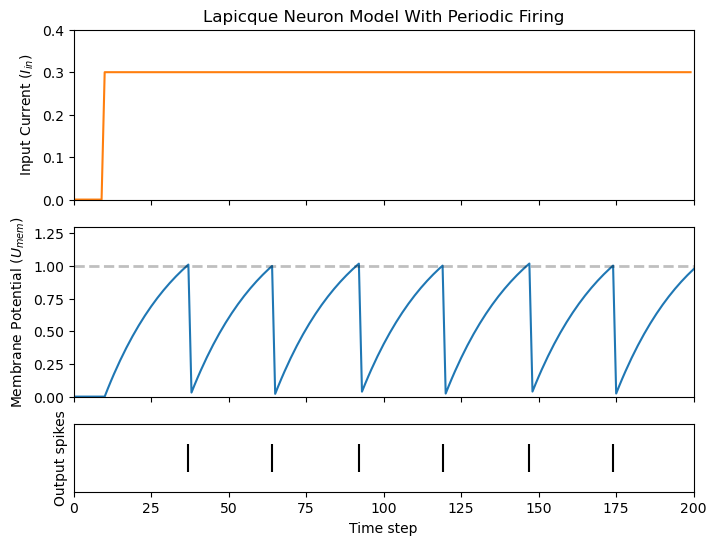

In [154]:
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)


cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)  
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]


for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)


mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3, 
                 title="Lapicque Neuron Model With Periodic Firing")

#### 閾値を小さくすることでより発火しやすくなる

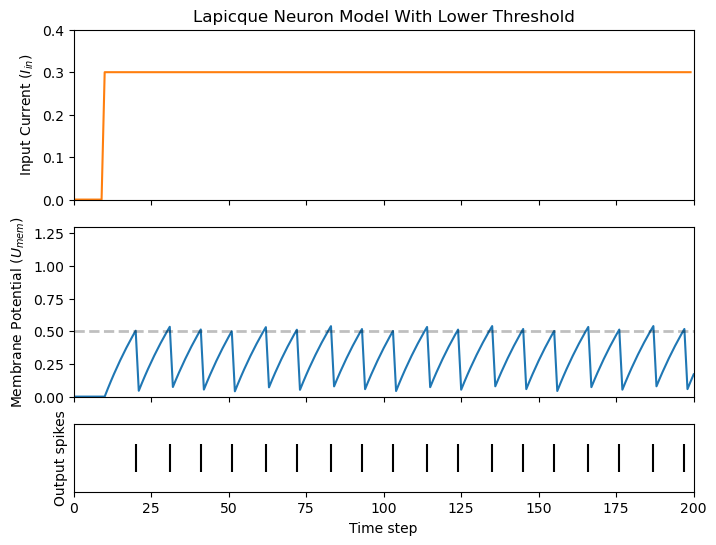

In [155]:

lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)


cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0) 
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]


for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)


mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3, 
                 title="Lapicque Neuron Model With Lower Threshold")

In [156]:
spk_in=spikegen.rate_conv(torch.ones((num_steps))*0.40)

#### 入力をニューロンにして出力もニューロンにする
- ランダムにスパイクを発火させてそれを入力にする

200の時間で76個のニューロンが発火した


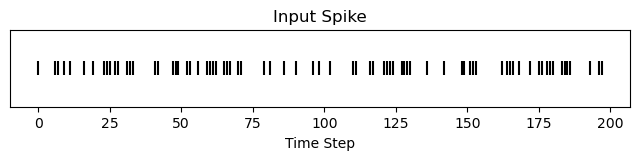

In [157]:
print(f'{len(spk_in)}の時間で{int(sum(spk_in))}個のニューロンが発火した')

fig=plt.figure(facecolor='w',figsize=(8,1))
ax=fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps,-1),ax,s=100,c='black',marker='|')
plt.title('Input Spike')
plt.xlabel('Time Step')
plt.yticks([])
plt.show()

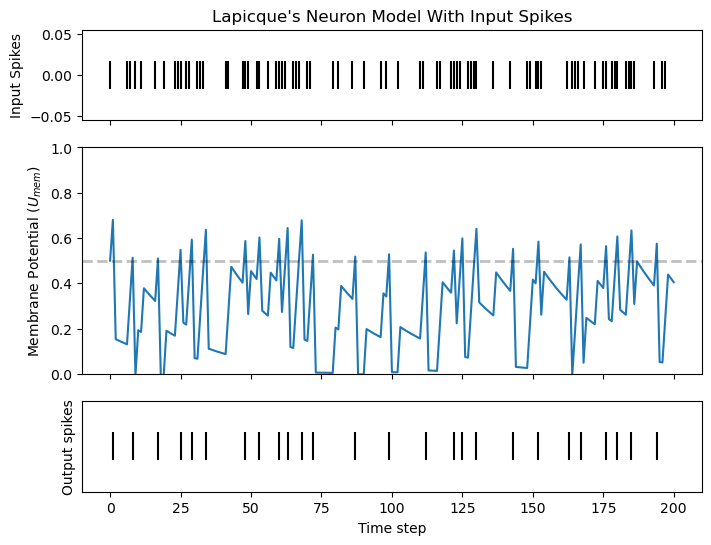

In [158]:
mem=torch.ones(1)*0.5
spk_out=torch.zeros(1)
mem_rec=[mem]
spk_rec=[spk_out]

for step in range(num_steps):
    spk_out,mem=lif3(spk_in[step],mem)
    mem_rec.append(mem)
    spk_rec.append(spk_out)

mem_rec=torch.stack(mem_rec)
spk_rec=torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")

#### 最後に発火したああとの膜電位をどこまで下げるのかについて
- reset_mechanismがzero の時は膜電位を0まで下げる<br>
subtractionの時は膜電位から閾値を引く
- デフォルトはsubtractionの方
- zeroの方は消費電力が場合によっては小さいというメリットがある

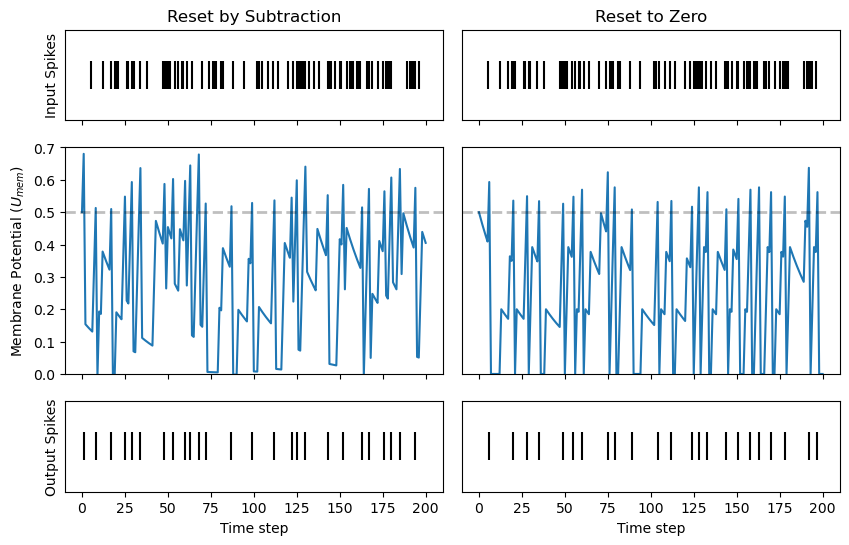

In [159]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)